# Predicting University Students’ Knowledge of DC Machines

Section 006, Group 27

Chantal, 
Yui, 
Ryan, 
Serena Zhang 72127699

## Loading the necessary libraries for our project and setting the seed

In [1]:
set.seed(0004)
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)
library(cowplot)
library(ggplot2)
library(digest)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Terminology 

STG - The degree of study time for goal object material - SCG - The degree of repetition number of user for goal object material - STR - The degree of study time of user for related objects with goal object - LPR - The exam performance of user for related objects with goal object - PEG - The exam performance of user for goal object - Class(UGC) - The knowledge level of user

### Background Information

A DC Machine is an energy conversion device that converts electrical energy to mechanical energy (Byju's, 2022). DC machines typically consist of a generator (which converts electrical energy to mechanical energy) and a motor (which converts mechanical energy to electrical energy). DC machines are typically used in settings where high starting torque and accurate speed control over a wide range are important. Some examples of the usage of DC machines include: elevators, steel mills, rolling mills, locomotives, and excavators. 

The goal of our project is to predict the degree of knowledge students have of electrical DC machines defined by the variable “class”. 403 university students were tested on their knowledge of DC machines through exam performances of the goal object and related goal object. Based on this, we aim to answer the question: how does the relationship between the exam performance levels of the goal object and related goal objects affect the user’s Electrical DC Machines knowledge level? If we are able to examine the goal object and related goal objects, then we can predict the knowledge level of participants. 

To answer the question, we will use the dataset provided by the University of California Irvine “User Modeling Data Set”, created by Hamdi Tolga Kahraman. The data set consists of 5 predictors: study time for the goal object, degree of repetition, study time for related objects, and exam performances of the object and related objects. The degree of knowledge can be predicted by examining the exam performance of the use for a related goal object (LPR) and examining the performance for the goal object (PEG). The student’s level of knowledge includes: very low, low, middle, and high. 


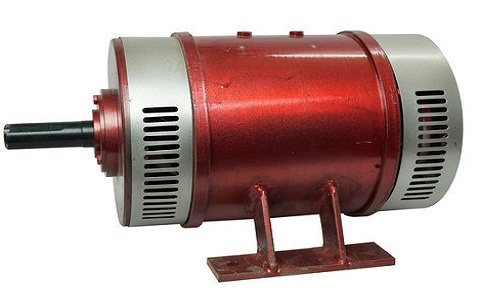

## Overview of Our Methods

First, we will read our data set and then clean and wrangle our data. Then we select only the required columns that we need for our analysis and convert the variable "class" into a factor. We then will visualize our data before using a k nearest neighbours model (with cross validation to find the optimal value of K) to predict the knowledge level of other students. The methodology is explained throughout the document.

### Reading and wrangling our data set

Our dataset can be found in the machine learning database. Rather than loading the dataset from a local environment, we directly imported it from the web. Since our data is already split into training and test data, we specify that we will be using *training* data. Our data contains extra columns so we will be specifying which ones we would like to use.

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"

download.file(url, destfile = "Knowledge.xls")

# Selecting the training data from sheet 2
knowledge_df <- read_excel(path = "Knowledge.xls", sheet = 2)

#renaming the variable "very_low" to "Very Low" in order to facilitate data analysis with test data later on
knowledge_df$UNS<- recode(knowledge_df$UNS,
                          "very_low" = "Very Low")
knowledge_df

New names:
• `` -> `...7`
• `` -> `...8`


STG,SCG,STR,LPR,PEG,UNS,...7,...8,Attribute Information:
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<chr>
0.00,0.00,0.00,0.00,0.00,Very Low,NA,NA,"STG (The degree of study time for goal object materails),"
0.08,0.08,0.10,0.24,0.90,High,NA,NA,SCG (The degree of repetition number of user for goal object materails)
0.06,0.06,0.05,0.25,0.33,Low,NA,NA,STR (The degree of study time of user for related objects with goal object)
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,High,NA,NA,NA
0.50,0.75,0.81,0.61,0.26,Middle,NA,NA,NA
0.66,0.90,0.76,0.87,0.74,High,NA,NA,NA


Selecting and factoring the necessary columns for our data analysis

In [3]:

knowledge <- mutate(knowledge_df, class=UNS) |>
         select(STG, SCG,STR,LPR,PEG,class) 
knowledge

STG,SCG,STR,LPR,PEG,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,Very Low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,High
0.50,0.75,0.81,0.61,0.26,Middle
0.66,0.90,0.76,0.87,0.74,High


Next, we used `mutate` and `as_factor` to convert the variable `class` into a factor. 

In [4]:
knowledge <- knowledge[order(knowledge$class),] |> mutate(class = as.factor(class))
knowledge

STG,SCG,STR,LPR,PEG,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.08,0.08,0.10,0.24,0.90,High
0.00,0.00,0.50,0.20,0.85,High
0.18,0.18,0.55,0.30,0.81,High
⋮,⋮,⋮,⋮,⋮,⋮
0.59,0.18,0.31,0.55,0.09,Very Low
0.60,0.19,0.55,0.08,0.10,Very Low
0.55,0.17,0.71,0.48,0.11,Very Low


Using `group_by` and `summarize` we will find the distribution of data by counting the number of each `class` variable. The `mutate` term is also used to determine the percentage distribution.

In [5]:
knowledge_proportions <- knowledge |>
                      group_by(class) |>
                      summarize(count = n()) |>
                      mutate(percent = 100*count/nrow(knowledge))
knowledge_proportions

class,count,percent
<fct>,<int>,<dbl>
High,63,24.418605
Low,83,32.170543
Middle,88,34.108527
Very Low,24,9.302326


We cleaned and wrangled the data by selecting only the columns we required for our data analysis. The percent distribution of each of the knowledge classes was determined useing the *mutate* term.

## Data Visualization

Next, the data will be visualized using scatter plots.

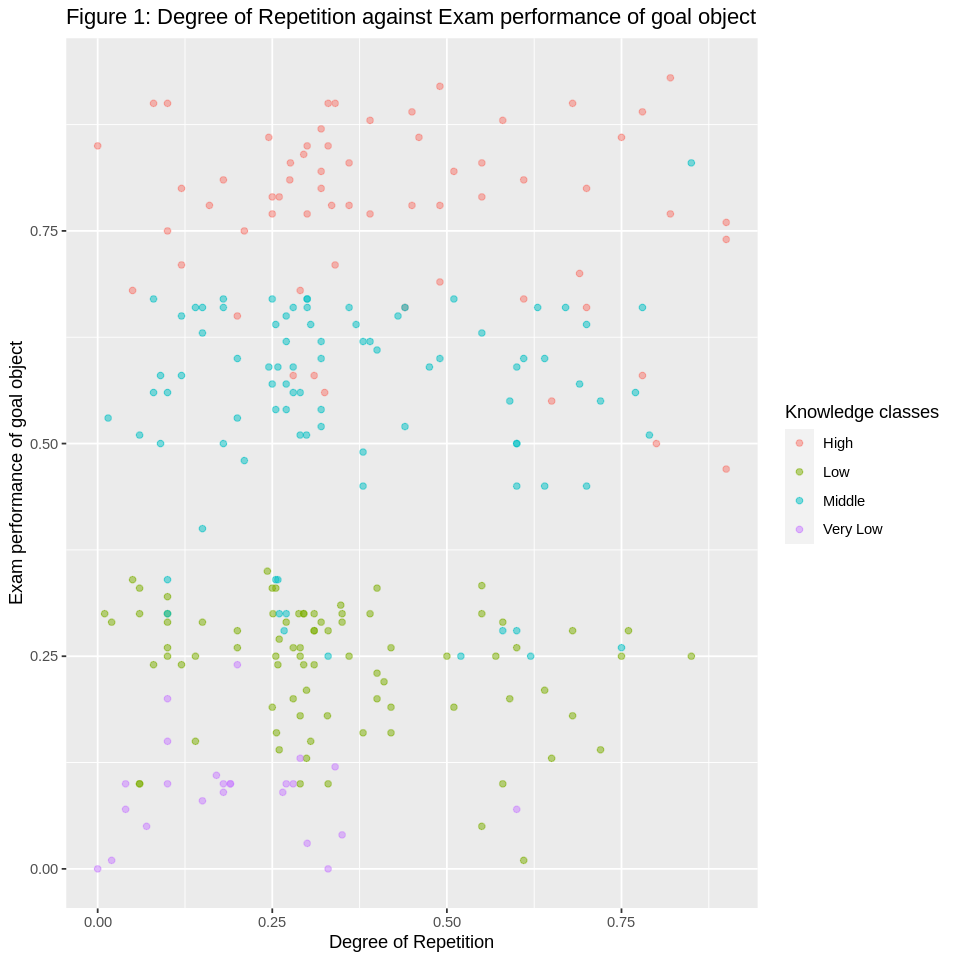

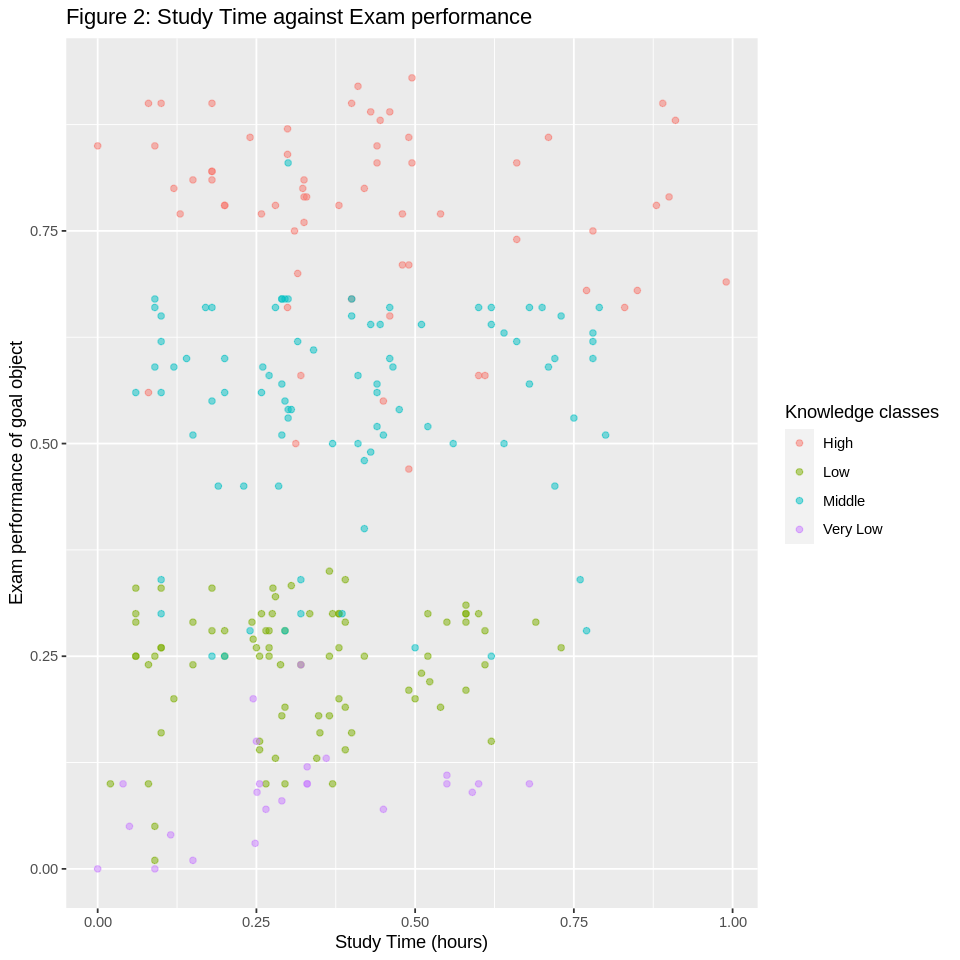

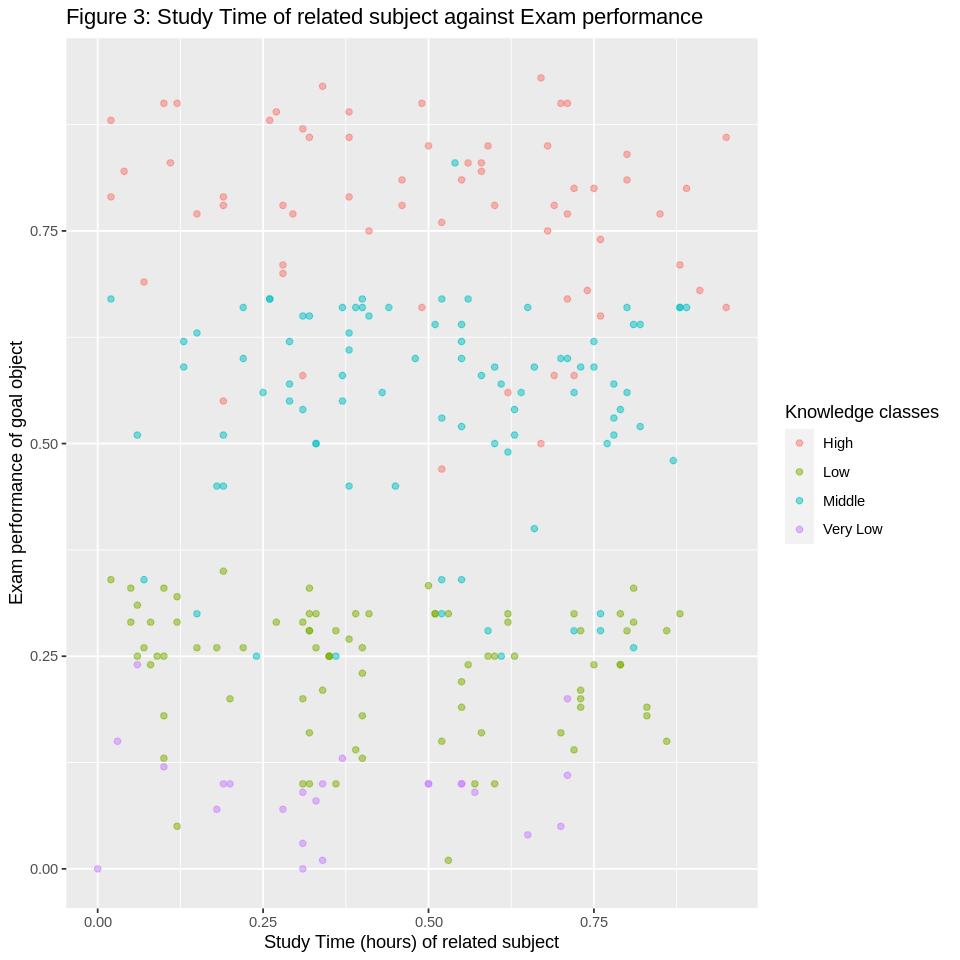

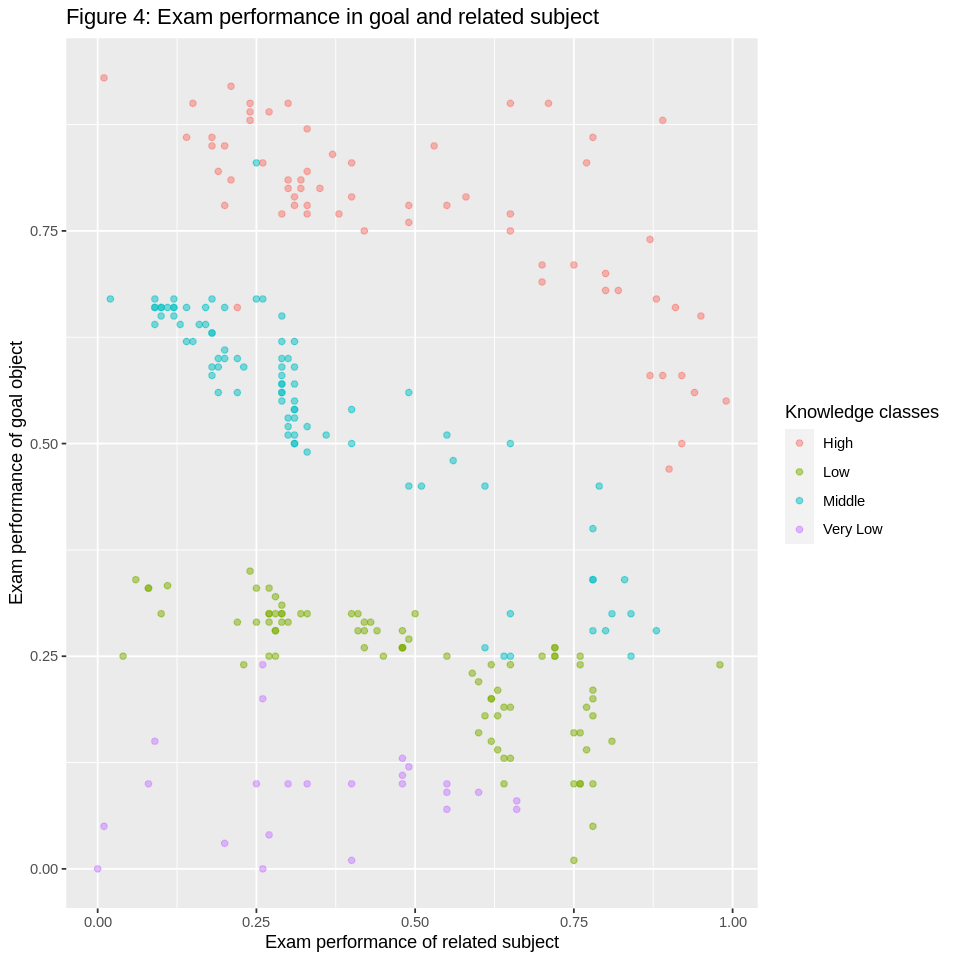

In [6]:
#visualizing initial plot to see which variable has highest influence
options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow = c(1, 2))
SCG_PEG_plot <- ggplot(knowledge, aes(x= SCG, y= PEG, colour = class)) + 
                      geom_point(alpha = 0.5) +
                        ggtitle("Figure 1: Degree of Repetition against Exam performance of goal object") +
                      labs(x="Degree of Repetition", y="Exam performance of goal object", color = "Knowledge classes")
SCG_PEG_plot

STG_PEG_plot <- ggplot(knowledge, aes(x= STG, y= PEG, colour = class)) + 
                      geom_point(alpha = 0.5) +
                        ggtitle("Figure 2: Study Time against Exam performance") +
                      labs(x="Study Time (hours)", y="Exam performance of goal object", color = "Knowledge classes")
STG_PEG_plot

STR_PEG_plot <- ggplot(knowledge, aes(x= STR, y= PEG, colour = class)) + 
                      geom_point(alpha = 0.5) +
                        ggtitle("Figure 3: Study Time of related subject against Exam performance") +
                      labs(x="Study Time (hours) of related subject", y="Exam performance of goal object", color = "Knowledge classes")
STR_PEG_plot

STR_PEG_plot <- ggplot(knowledge, aes(x= LPR, y= PEG, colour = class)) + 
                      geom_point(alpha = 0.5) +
                    ggtitle("Figure 4: Exam performance in goal and related subject") +
                      labs(x="Exam performance of related subject", y="Exam performance of goal object", color = "Knowledge classes")
STR_PEG_plot

We chose to use scatter plots as they best represented the relationship between the variables we chose. The scatter plots makes it easier to see the relationship between the variables and the knowledge classes. The knowledge classes were colour coded to help visualize the distribution. This is done to prepare for later steps, which are related to predicting the knowledge classes. 

## Using Cross-Validation to Choose K

In [22]:
knowledge_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
                  set_engine("kknn") |>
                  set_mode("regression") 

knowledge_recipe <- recipe(class~ LPR+PEG, data = knowledge) |>
                  step_scale(all_predictors()) |>
                  step_center(all_predictors())

knowledge_vfold <- vfold_cv(knowledge, v=10, strata = class)

knowledge_workflow <- workflow() |>
                    add_recipe(knowledge_recipe) |>
                    add_model(knowledge_spec)
knowledge_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [24]:
set.seed(0004)
gridvals <- tibble(neighbors = 1:200)

knowledge_rmse <- knowledge_workflow|>
    tune_grid(resamples = knowledge_vfold, grid = gridvals)|>
    collect_metrics()|>
    filter(.metric == "rmse")

knowledge_k_value <- knowledge_rmse |>
    filter(mean == min(mean))|>
    pull(neighbors)
    
tennis_k_value

x Fold01: preprocessor 1/1, model 1/1:
  Error in `check_outcome()`:
  ! For a regression model, the outcome should be numeric.

x Fold02: preprocessor 1/1, model 1/1:
  Error in `check_outcome()`:
  ! For a regression model, the outcome should be numeric.

x Fold03: preprocessor 1/1, model 1/1:
  Error in `check_outcome()`:
  ! For a regression model, the outcome should be numeric.

x Fold04: preprocessor 1/1, model 1/1:
  Error in `check_outcome()`:
  ! For a regression model, the outcome should be numeric.

x Fold05: preprocessor 1/1, model 1/1:
  Error in `check_outcome()`:
  ! For a regression model, the outcome should be numeric.

x Fold06: preprocessor 1/1, model 1/1:
  Error in `check_outcome()`:
  ! For a regression model, the outcome should be numeric.

x Fold07: preprocessor 1/1, model 1/1:
  Error in `check_outcome()`:
  ! For a regression model, the outcome should be numeric.

x Fold08: preprocessor 1/1, model 1/1:
  Error in `check_outcome()`:
  ! For a regression model, 

ERROR: [1m[33mError[39m in [1m[1m`estimate_tune_results()`:[22m
[33m![39m All of the models failed. See the .notes column.


## Discussion

### Findings

By looking at the graphs, we notice that there are correlations between some variables with the exam scores.  

### Expected outcomes 

When comparing all the provided variables, we expected that the gained knowledge would be directly related to the amount of time spent studying the goal object and its exam performance. However, after plotting these variables, we found that there was no correlation between PEG, STG and the user's knowledge. Alternatively, we observed that there is a significant positive relationship between LPR, PEG and the user's knowledge.

### Significance

We do not believe that the finding of this dataset will be very impactful. The relationship between knowledge and exam performance is not an accurate representation of knowledge retention. Factors such as test anxiety negatively impact a person's ability to score well on tests despite having a high degree of knowledge. Additionally, we believe that the amount of time a person studies any given material should have a significant impact on their knowledge. 

### Further questions 

Considering these factors, we may ask ourselves *are there better means of collecting this data or are there other more impactful factors that aren't being considered in this study?*

## References
##### These include citations for all images used, background information and the dataset we used

- BYJU'S. (2022, May 13). DC motor - definition, working, types, and faqs. BYJUS. Retrieved April 8, 2023, from https://byjus.com/physics/dc-motor/#:~:text=A%20DC%20motor%20is%20an,transformed%20into%20the%20mechanical%20rotation. 

- Kahraman, H. T., Colak, I., &amp; Sagiroglu, S. (2013, June 26). User Knowledge Modeling Data Set. UCI Machine Learning Repository: User knowledge modeling data set. Retrieved April 8, 2023, from https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling 
